In [ ]:
# imports
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn_sfa_master.sksfa import HSFA

In [ ]:
# Load data & crop / reduce size if dim_step > 1
data = np.load('data/data_squareRoom.npy')
crop_h = 20
crop_w = 10
dim_step= 1
data = data[:, crop_h:-crop_h, crop_w:-crop_w][:, ::dim_step][:, :, ::dim_step]
gc.collect()
print(data.shape)

(22000, 30, 190, 3)


In [ ]:
# standardize images
images = np.array([(image - image.min()) / (image.max() - image.min()) for image in data])
print(images[0].shape)

# init. HSFA 
layer_configurations = [(10, 10, 5, 5, 5, 2)]
hsfa = HSFA(4, images.shape[1:], layer_configurations, verbose=True)
hsfa = hsfa.fit(images)
slow_features = hsfa.transform(images)

(30, 190, 3)


pos 1: [ 0.33307696  2.70042347  0.12188137 -0.28856299]
pos 2: [ 0.29348643  2.74176402 -0.59524317 -0.39901361]
Change: [0.03959053 0.04134055 0.71712455 0.11045063]
Max diff.: Slow feature #3


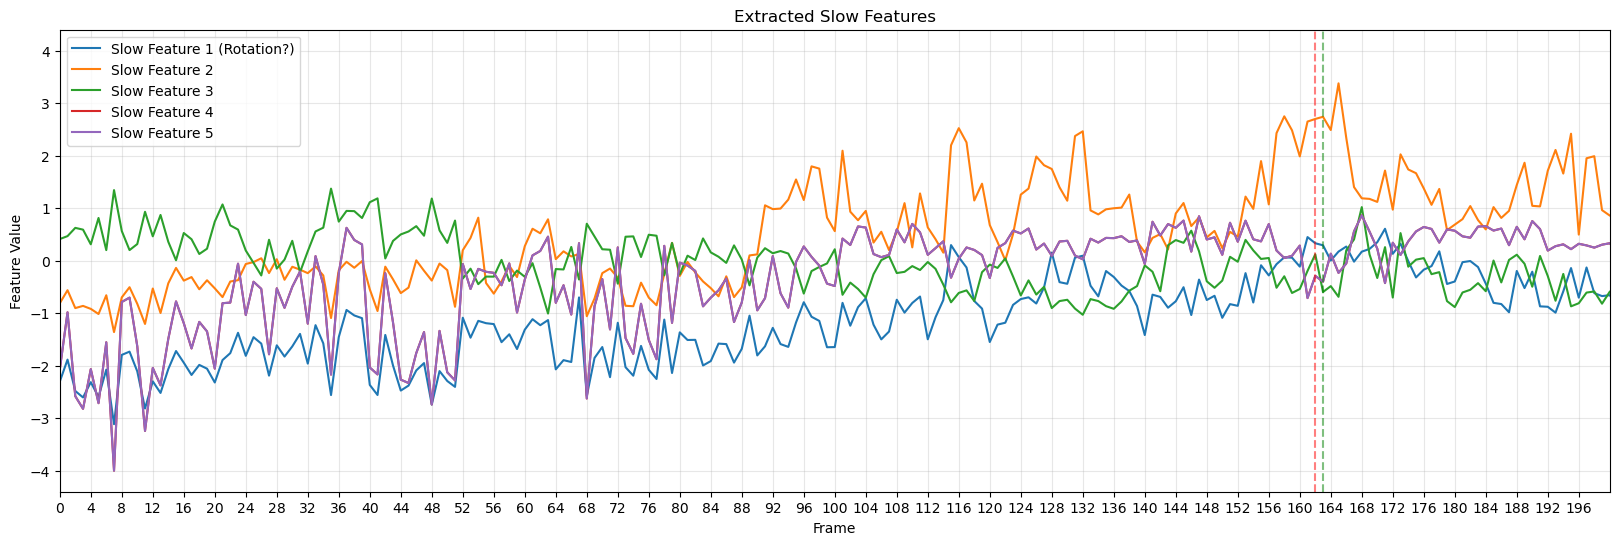

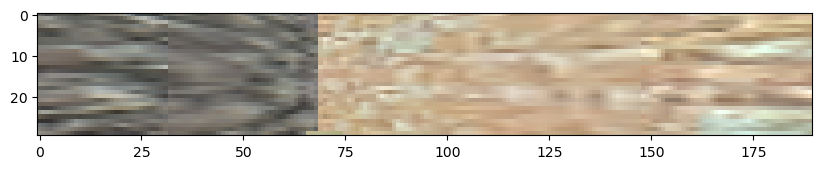

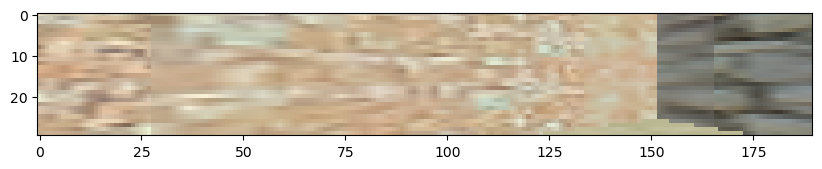

In [ ]:
# Plot 5 slowest features
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()

# Compare two images 
index1 = 162
index2 = index1+1

ax.plot(slow_features[:, 0], label="Slow Feature 1 (Rotation?)")
ax.plot(slow_features[:, 1], label="Slow Feature 2")
ax.plot(slow_features[:, 2], label="Slow Feature 3")
ax.plot(slow_features[:, 3], label="Slow Feature 4")
ax.plot(slow_features[:, 3], label="Slow Feature 5")
print('pos 1:', slow_features[index1])
print('pos 2:', slow_features[index2])
print('Change:', np.abs(slow_features[index1] - slow_features[index2]))
print(f'Max diff.: Slow feature #{np.argmax(np.abs(slow_features[index1] - slow_features[index2])) + 1}')
ax.legend()
ax.grid(alpha=.3)
hline = ax.axvline(index1, c='r', alpha=.5, linestyle='--')
hline = ax.axvline(index2, c='g', alpha=.5, linestyle='--')
plt.title("Extracted Slow Features")
plt.xlabel("Frame")
plt.ylabel("Feature Value")
length = 200
steps = 4
plt.xlim(0,length)
plt.xticks(np.arange(0, length, steps))

plt.figure(figsize=(10, 5))
plt.imshow(data[index1])
plt.figure(figsize=(10, 5))
plt.imshow(data[index2])
plt.show()

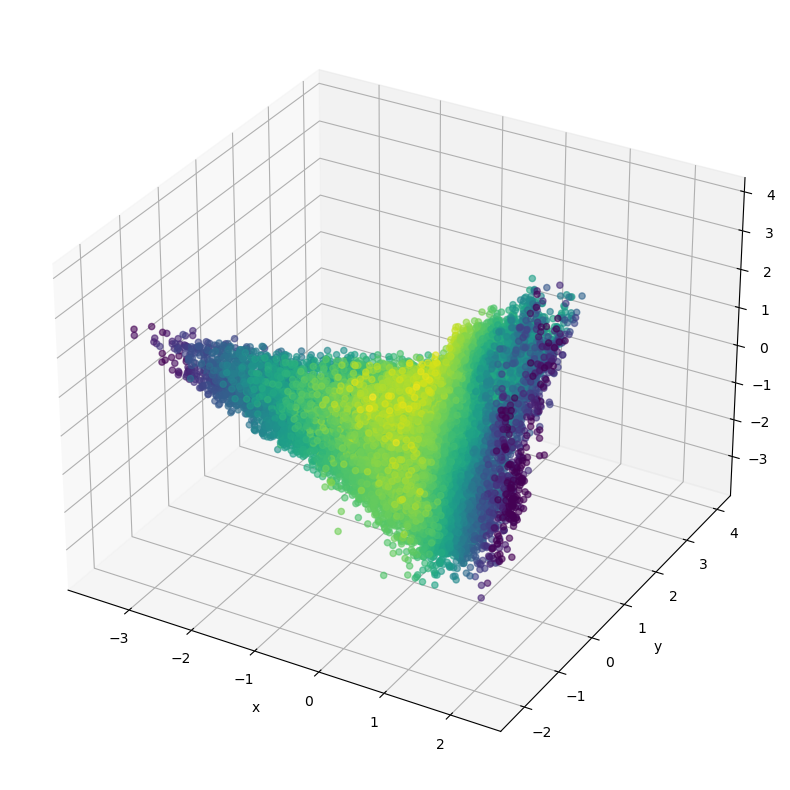

In [ ]:
# Scatter plot of first 4 features (not really useful)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(slow_features[:,0], slow_features[:,1], slow_features[:,2], c=slow_features[:,3], cmap='viridis', alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# init. SOM & find winners

from minisom import MiniSom
from tqdm.notebook import tqdm
print(round(np.sqrt(100**2 + 100**2)))
som = MiniSom(200, 200, 10, sigma=3, learning_rate=0.5)
som.random_weights_init(slow_features[:,0:])
som.train(slow_features[:,0:], 5000, random_order=True, verbose=True)
winners = [som.winner(x) for x in tqdm(slow_features[:,0:])]

In [ ]:
# plot SOM & compare two images

index = 45
index2 = index+1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
winners = np.array(winners)
ax.scatter(winners[:,0], winners[:,1], np.add(slow_features[:,0], slow_features[:,3]), marker='.', c='black', alpha=.1)
ax.plot(winners[index,0], winners[index,1], slow_features[index,0] + slow_features[index,3], 'ro', label='first image')
ax.plot(winners[index2,0], winners[index2,1], slow_features[index2,0] + slow_features[index2,3], 'bo', label='second image')
ax.legend()
ax.view_init(elev=30, azim=-45)
plt.xlabel('x')
plt.ylabel('y')
plt.figure(figsize=(10, 10))

combined = np.add(slow_features[:,0], slow_features[:,3])
scaledRotation = (combined - np.min(combined)) / (np.max(combined) - np.min(combined))

plt.scatter(winners[:,0], winners[:,1], marker='.', c=scaledRotation, cmap='hot', alpha=.5)
cbar = plt.colorbar()
plt.plot(winners[index,0], winners[index,1], 'go', label='first image')
plt.plot(winners[index2,0], winners[index2,1], 'bo', label='second image')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.figure(figsize=(10, 6))
plt.imshow(data[index])
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(10, 6))
plt.imshow(data[index2])
plt.xticks([])
plt.yticks([])
plt.show()

<h1>Use own recorded data</h1>

In [ ]:
# Load recorded data & stitch them together, outcome: dataset w/ shape (3000, 30, 190, 3)
# & perform SFA

recorded_data = []
pos_data = []

camera_only_rot = np.load('recorded_data/dataset/camera_only_rot.npy')
camera_no_rot = np.load('recorded_data/dataset/camera_no_rot.npy')
camera = np.load('recorded_data/dataset/camera.npy')

pos_only_rot = np.load('recorded_data/dataset/position_only_rot.npy')
pos_no_rot = np.load('recorded_data/dataset/position_no_rot.npy')
pos = np.load('recorded_data/dataset/position.npy')

dataset = np.zeros((3000, 30, 190, 3))
positions = np.zeros((3000,4))

for i in range(len(dataset)):
    if i < 1000:
        dataset[i] = camera_only_rot[i]
        positions[i] = pos_only_rot[i]
    elif i < 2000:
        dataset[i] = camera_no_rot[i-1000]
        positions[i] = pos_no_rot[i-1000]
    else:
        dataset[i] = camera[i-2000]
        positions[i] = pos[i-2000]

images = np.array([(image - image.min()) / (image.max() - image.min()) for image in dataset])
slow_features = hsfa.transform(images)


In [ ]:
# Plot three slowest features
plt.figure(figsize=(20, 6))
plt.plot(slow_features[:,0], label='sf#1')
plt.plot(slow_features[:,1])
plt.plot(slow_features[:,2])
plt.xlim([0, 200])
plt.grid()
plt.legend()
plt.figure()
plt.imshow(images[100])
plt.figure()
plt.imshow(images[101])
plt.show()
print(positions[100], positions[101])

In [ ]:
# SOM for recorded data
winners = [som.winner(x) for x in tqdm(slow_features[:1000])]
winners = np.array(winners)
plt.figure(figsize=(10, 10))
plt.scatter(winners[:,0], winners[:,1], marker='.', alpha=.5)
plt.show()